In [1]:
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import ShuffleSplit
import pickle

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
#device = torch.device('cpu')

torch.backends.cudnn.benchmark = True
from scipy import stats

import contrastive_functions

In [2]:
# read python dict back from the file

# data_file = open('../data/SPK20220308/neuron_num_results/num_neuron_results_fold0_10repeats_cam1_l1dist.pkl', 'rb')
data_file = open('../data/SPK20220308/neuron_num_results/num_neuron_results_fold0_20repeats_cam1_cosinedist_2back.pkl', 'rb')
# data_file = open('../data/SPK20220308/neuron_num_results/neuron_sort_results.pkl', 'rb')

num_neuron_dict = pickle.load(data_file)
data_file.close()

In [3]:
marker_list = ['indexProx', 'thumbProx', 'ringProx', 'carpal', 'pinkyProx', 'middleProx']
marker_titles= np.concatenate([[f'{mrk}_x', f'{mrk}_y'] for mrk in marker_list])

In [4]:
num_repeats = num_neuron_dict['num_repeats']
num_neuron_list = num_neuron_dict['num_neuron_list']
num_neuron_list = [2,4,6,8,10,15,25,35]

# num_neuron_list = [6,10]

num_repeats = 20

task_res = list()
notask_res = list()
for repeat_idx in range(num_repeats):
    task_test_corr = list()
    notask_test_corr = list()
    for num_neurons in num_neuron_list:
        res_dict = num_neuron_dict[f'repeat_{repeat_idx}'][f'num_neuron_{num_neurons}']
        task_test_corr.append(np.stack(res_dict['rnn']['task']['test_corr']))
        notask_test_corr.append(np.stack(res_dict['rnn']['notask']['test_corr']))

    task_res.append(np.stack(task_test_corr))
    notask_res.append(np.stack(notask_test_corr))

task_res = np.stack(task_res)
notask_res = np.stack(notask_res)


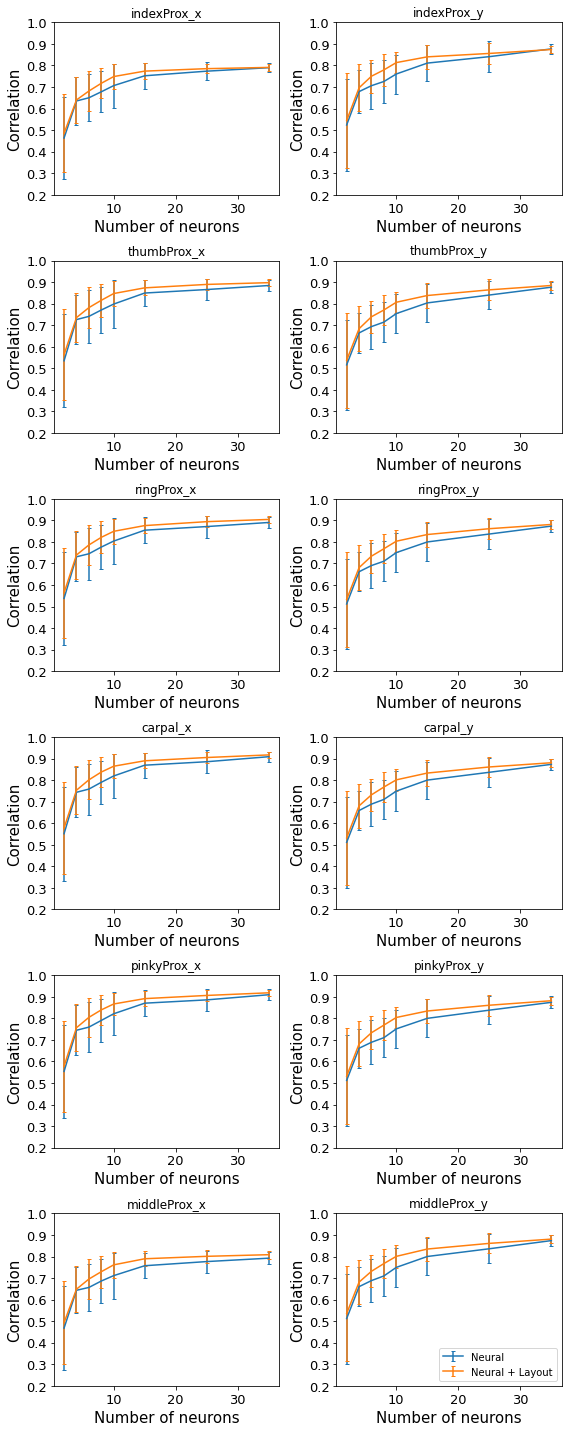

In [5]:
task_mean = np.mean(task_res, axis=0)
task_std = np.std(task_res,  axis=0)

notask_mean = np.mean(notask_res, axis=0)
notask_std = np.std(notask_res,  axis=0)

labelsize=15
ticksize=13

plt.figure(figsize=(8,20))
for plot_idx in range(12):
    plt.subplot(6,2,plot_idx+1)
    plt.errorbar(x=num_neuron_list, y=notask_mean[:,plot_idx], yerr=notask_std[:,plot_idx], capsize=2, label='Neural')
    plt.errorbar(x=num_neuron_list, y=task_mean[:,plot_idx], yerr=task_std[:,plot_idx], capsize=2, label='Neural + Layout')


    plt.tight_layout()
    plt.ylim(0.2,1)

    plt.xlabel('Number of neurons', fontsize=labelsize)
    plt.ylabel('Correlation', fontsize=labelsize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.tight_layout()
    plt.title(marker_titles[plot_idx])
plt.legend()
plt.savefig('num_neuron_curve.svg')

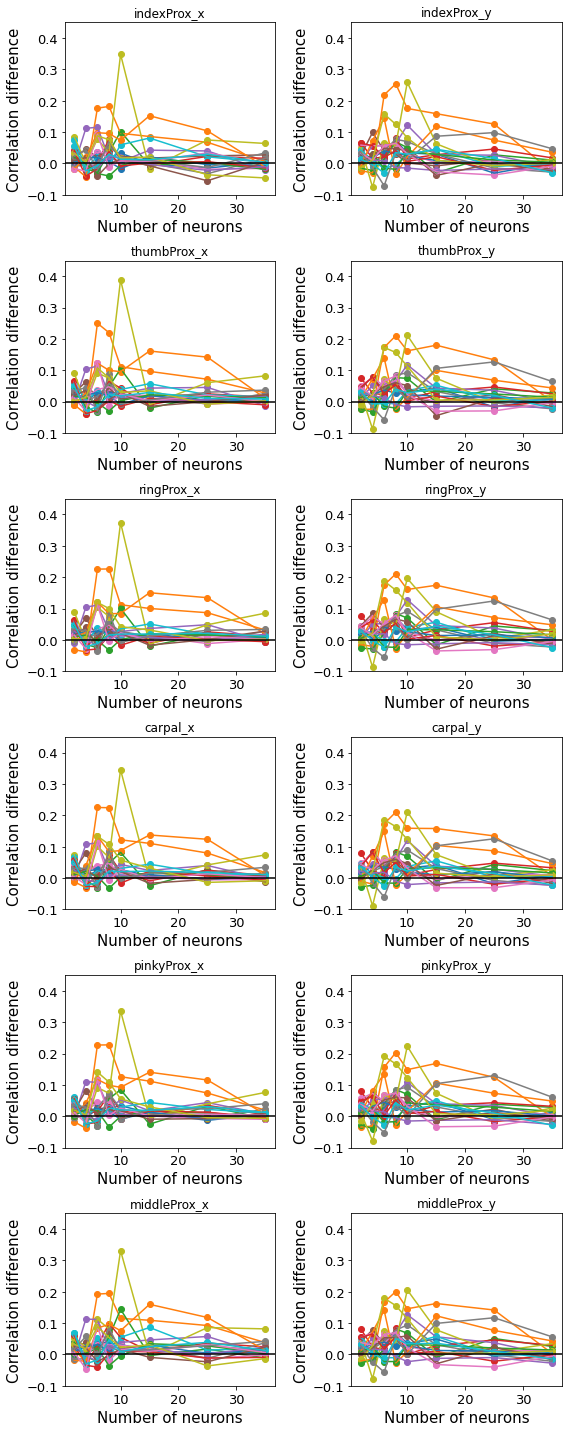

In [42]:
task_mean = np.mean(task_res, axis=0)
task_std = np.std(task_res,  axis=0)

notask_mean = np.mean(notask_res, axis=0)
notask_std = np.std(notask_res,  axis=0)

plt.figure(figsize=(8,20))
for plot_idx in range(12):
    plt.subplot(6,2,plot_idx+1)
    # plt.errorbar(x=num_neuron_list, y=notask_mean[:,plot_idx], yerr=notask_std[:,plot_idx])
    # plt.errorbar(x=num_neuron_list, y=task_mean[:,plot_idx], yerr=task_std[:,plot_idx])
    for repeat_idx in range(num_repeats):

        corr_diff = task_res[repeat_idx, :, plot_idx] - notask_res[repeat_idx, :, plot_idx]
        # plt.plot(task_res[repeat_idx, :, plot_idx], color=f'C{repeat_idx}')
        # plt.plot(notask_res[repeat_idx, :, plot_idx], color=f'C{repeat_idx}')
        plt.scatter(num_neuron_list, corr_diff)
        plt.plot(num_neuron_list, corr_diff)
        plt.ylabel('Correlation difference', fontsize=labelsize)
        plt.xlabel('Number of neurons', fontsize=labelsize)
        plt.xticks(fontsize=ticksize)
        plt.yticks(fontsize=ticksize)

    plt.tight_layout()
    plt.axhline(y=0, color='k')
    plt.ylim(-0.1, 0.45)
    plt.title(marker_titles[plot_idx])

# plt.savefig('num_neuron_correlation_diff.svg')

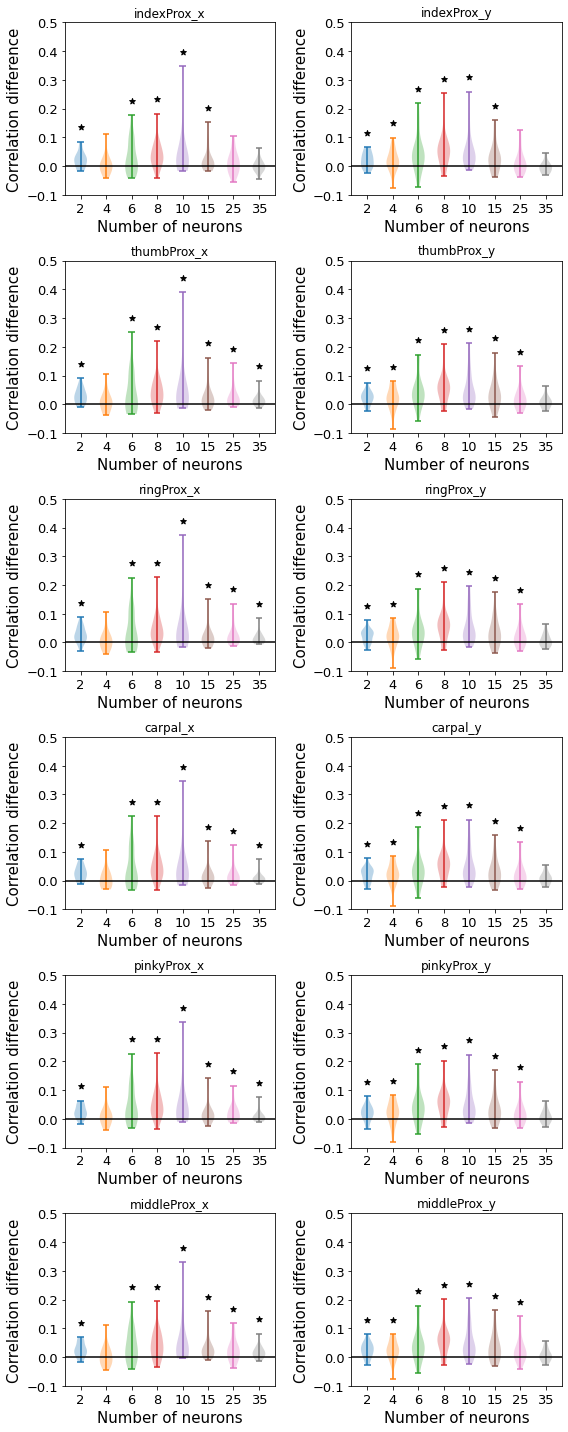

In [20]:
task_mean = np.mean(task_res, axis=0)
task_std = np.std(task_res,  axis=0)

notask_mean = np.mean(notask_res, axis=0)
notask_std = np.std(notask_res,  axis=0)

plt.figure(figsize=(8,20))
for plot_idx in range(12):
    plt.subplot(6,2,plot_idx+1)
    # plt.errorbar(x=num_neuron_list, y=notask_mean[:,plot_idx], yerr=notask_std[:,plot_idx])
    # plt.errorbar(x=num_neuron_list, y=task_mean[:,plot_idx], yerr=task_std[:,plot_idx])
    for num_neuron_idx in range(len(num_neuron_list)):

        corr_diff = task_res[:, num_neuron_idx, plot_idx] - notask_res[:, num_neuron_idx, plot_idx]
        ttest = stats.ttest_1samp(corr_diff, popmean=0, alternative='greater')
        if ttest.pvalue < 0.05:
            plt.scatter([num_neuron_idx], np.max(corr_diff) + 0.05, marker='*', color='k')
        else:
            plot_color='k'

        _ = plt.violinplot(corr_diff, positions=[num_neuron_idx])


        plt.ylabel('Correlation difference', fontsize=labelsize)
        plt.xlabel('Number of neurons', fontsize=labelsize)

    plt.xticks(ticks=range(len(num_neuron_list)), labels=num_neuron_list, fontsize=ticksize)
    plt.yticks(fontsize=ticksize)

    plt.tight_layout()
    plt.axhline(y=0, color='k')
    plt.ylim(-0.1, 0.5)
    plt.title(marker_titles[plot_idx])

plt.savefig('num_neuron_correlation_diff.svg')

In [46]:
neural_offset = 10 # try 50-150 ms offset
window_size = 70
label_col = 'layout'

noise_fold = 0
data_dict = contrastive_functions.get_marker_decode_dataframes(noise_fold = noise_fold, cam_idx=1)
wrist_df = data_dict['wrist_df']
task_neural_df = data_dict['task_neural_df']
notask_neural_df = data_dict['notask_neural_df']
metadata = data_dict['metadata']
cv_dict = data_dict['cv_dict']

neuron_list = notask_neural_df['unit'].unique()

/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [47]:
data_arrays, generators = contrastive_functions.make_generators(
    wrist_df, notask_neural_df, neural_offset, cv_dict, metadata, exclude_neural=None,
    window_size=window_size, flip_outputs=True, batch_size=1000, label_col='layout')

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

test_labels = testing_set[:][2].detach().cpu().numpy()

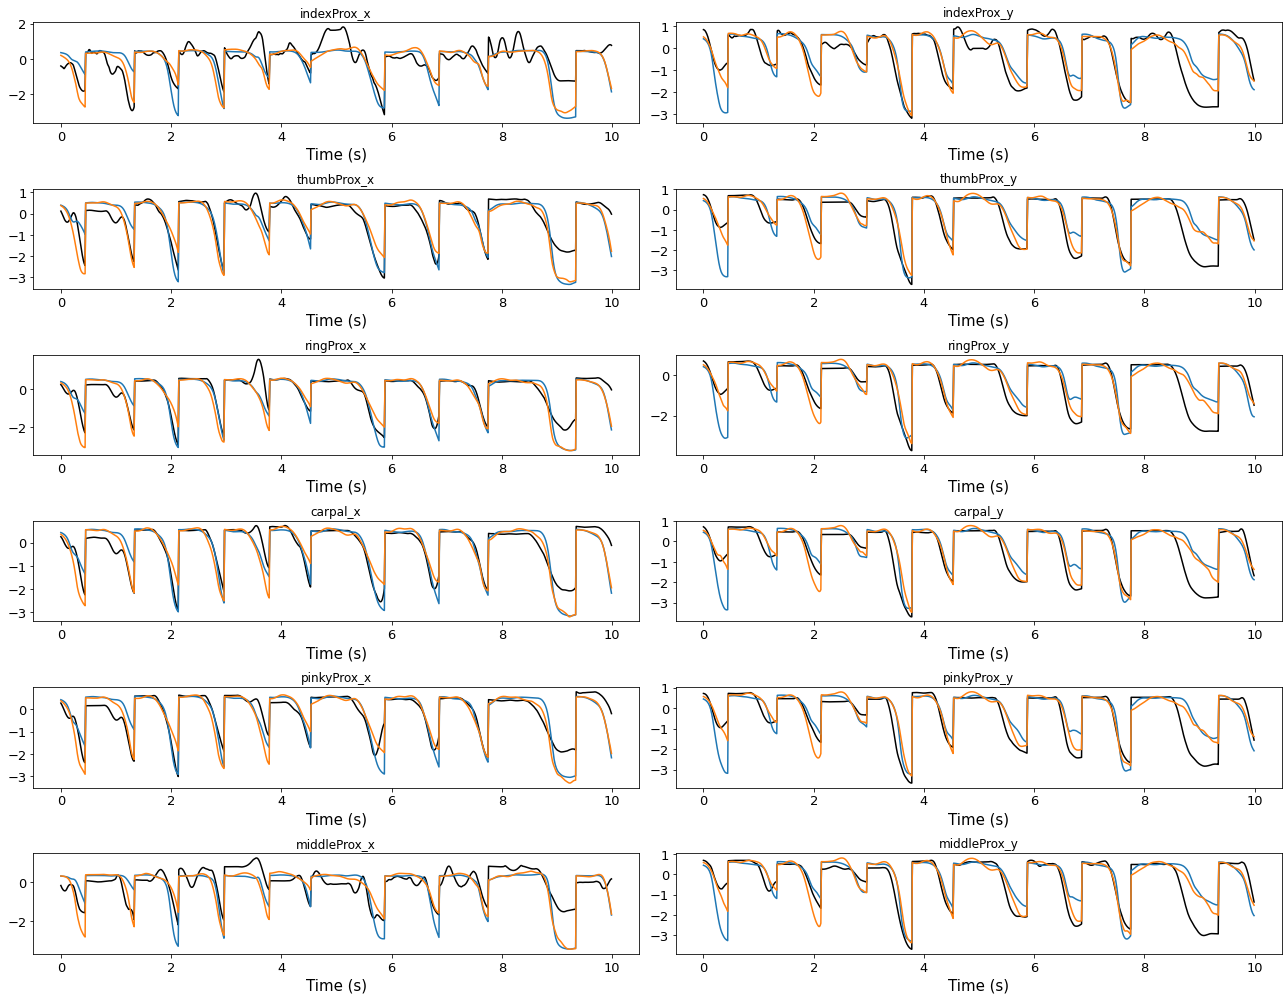

In [58]:
# time_offset = 1000
time_offset = 3400

bounds = list(range(0+time_offset,1000+time_offset))
x_times = np.arange(len(bounds)) / 100 # Sampling rate=100 Hz

# repeat_name = 'repeat_0'
# num_neuron_name = 'num_neuron_15'

repeat_name = 'repeat_19'
num_neuron_name = 'num_neuron_15'

plt.figure(figsize=(18,14))
for mrk_idx in range(12):
    plt.subplot(6,2,mrk_idx+1)
    plt.plot(x_times, y_test_data[bounds,mrk_idx], color='k')
    plt.plot(x_times, num_neuron_dict[repeat_name][num_neuron_name]['rnn']['notask']['test_pred'][bounds,mrk_idx])
    plt.plot(x_times, num_neuron_dict[repeat_name][num_neuron_name]['rnn']['task']['test_pred'][bounds,mrk_idx])
    plt.xlabel('Time (s)', fontsize=labelsize)

    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.title(marker_titles[mrk_idx])
plt.tight_layout()
# plt.savefig('num_neuron_marker_trajectory.svg')


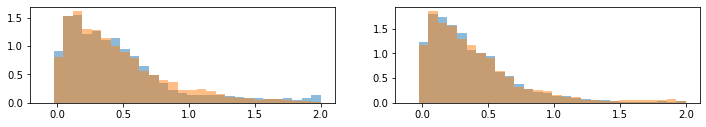

In [53]:
# repeat_name = 'repeat_3'
# num_neuron_name = 'num_neuron_30'

bins = np.linspace(-0.1, 2, 30)
plt.figure(figsize=(12,6))
for mrk_idx in range(2):
    plt.subplot(3,2,mrk_idx+1)

    notask_mse = np.abs(num_neuron_dict[repeat_name][num_neuron_name]['rnn']['notask']['test_pred'][:,mrk_idx] - y_test_data[:,mrk_idx])
    task_mse = np.abs(num_neuron_dict[repeat_name][num_neuron_name]['rnn']['task']['test_pred'][:,mrk_idx] - y_test_data[:,mrk_idx])

    plt.hist(notask_mse, bins=bins, alpha=0.5, density=True)
    plt.hist(task_mse, bins=bins, alpha=0.5, density=True)
